In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,IsolationForest
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  20

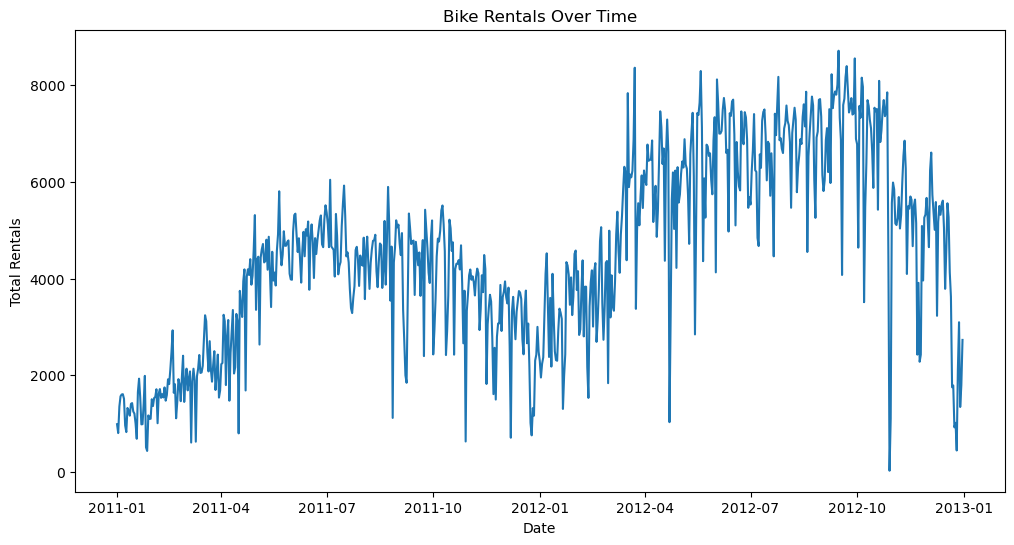

In [2]:

df = pd.read_csv("day.csv")


print(df.info())
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

df['dteday'] = pd.to_datetime(df['dteday'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='dteday', y='cnt')
plt.title("Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.show()


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 R^2 Score: 0.886653881755698


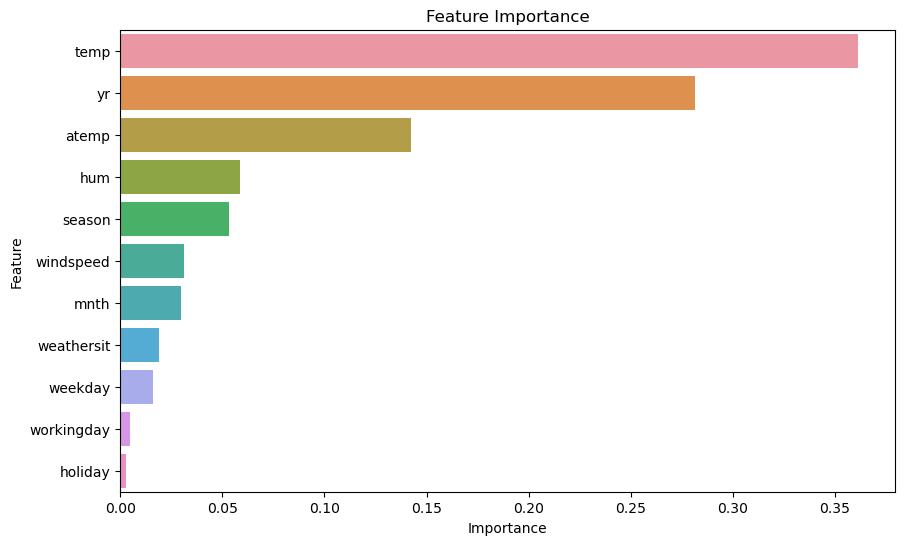

In [3]:

columns_to_drop = ["instant", "casual", "registered"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Identify categorical columns for one-hot encoding
categorical_cols = ["season", "mnth", "weekday", "weathersit"]
categorical_cols = [col for col in categorical_cols if col in df.columns and df[col].dtype == 'object']

# Convert categorical variables to dummy variables if they exist
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(columns=["cnt", "dteday"]) 
y = df["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


y_pred = best_rf.predict(X_test)


r2 = r2_score(y_test, y_pred)

print(f" R^2 Score: {r2}")

feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

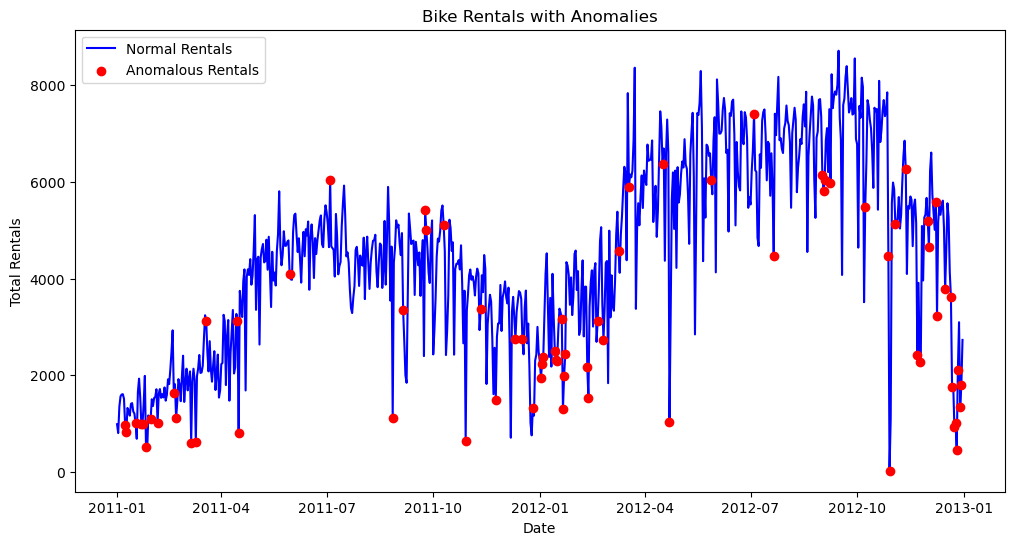

Percentage of anomalies: 9.99%


In [4]:
from sklearn.ensemble import IsolationForest


isolation_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = isolation_forest.fit_predict(X)


anomaly_data = df[df['anomaly'] == -1]

plt.figure(figsize=(12, 6))
plt.plot(df['dteday'], df['cnt'], label='Normal Rentals', color='blue')
plt.scatter(anomaly_data['dteday'], anomaly_data['cnt'], label='Anomalous Rentals', color='red', zorder=5)
plt.title("Bike Rentals with Anomalies")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.legend()
plt.show()
anomaly_percentage = anomaly_data.shape[0] / df.shape[0] * 100
print(f"Percentage of anomalies: {anomaly_percentage:.2f}%")


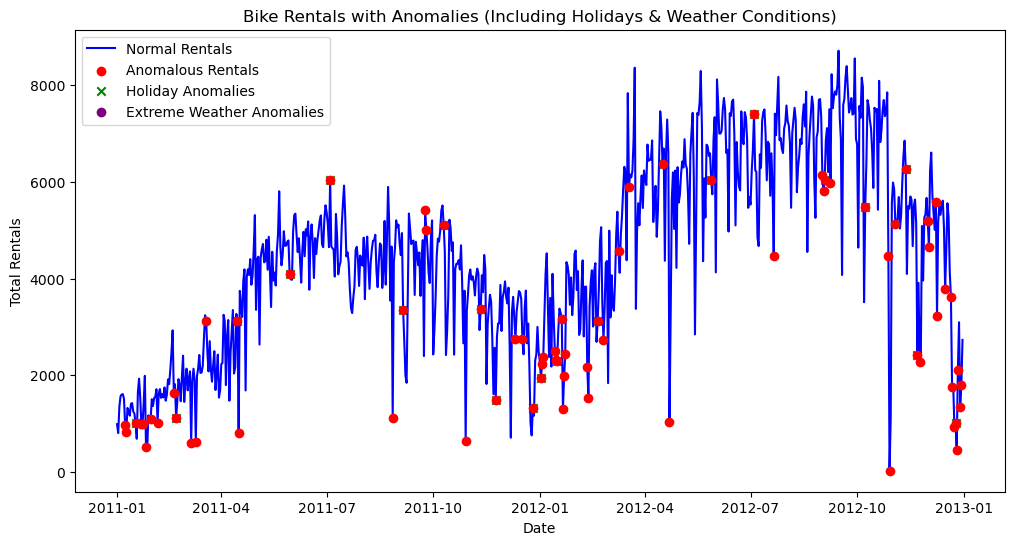

Percentage of anomalies caused by holidays: 28.77%
Percentage of anomalies caused by extreme weather: 0.00%


In [5]:
anomaly_data = df[df['anomaly'] == -1].copy()  # Make a copy of the anomalies to avoid modifying a slice directly

anomaly_data.loc[:, 'is_holiday'] = anomaly_data['holiday']
anomaly_data.loc[:, 'weather_condition'] = anomaly_data['weathersit']

plt.figure(figsize=(12, 6))
plt.plot(df['dteday'], df['cnt'], label='Normal Rentals', color='blue')
plt.scatter(anomaly_data['dteday'], anomaly_data['cnt'], label='Anomalous Rentals', color='red', zorder=5)

# Add holiday events to the plot
holiday_anomalies = anomaly_data[anomaly_data['is_holiday'] == 1]
plt.scatter(holiday_anomalies['dteday'], holiday_anomalies['cnt'], label='Holiday Anomalies', color='green', marker='x')

# Add weather conditions to the plot
weather_anomalies = anomaly_data[anomaly_data['weather_condition'] == 4]  # Extreme weather (e.g., snow/fog)
plt.scatter(weather_anomalies['dteday'], weather_anomalies['cnt'], label='Extreme Weather Anomalies', color='purple', marker='o')

# Enhance the plot
plt.title("Bike Rentals with Anomalies (Including Holidays & Weather Conditions)")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.legend()
plt.show()

# Investigate what percentage of anomalies are due to holidays and extreme weather
holiday_percentage = holiday_anomalies.shape[0] / anomaly_data.shape[0] * 100
weather_percentage = weather_anomalies.shape[0] / anomaly_data.shape[0] * 100

print(f"Percentage of anomalies caused by holidays: {holiday_percentage:.2f}%")
print(f"Percentage of anomalies caused by extreme weather: {weather_percentage:.2f}%")
